### Loading Glove Embeddings

In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Load GloVe Embeddings
def load_glove_embeddings(glove_path, embedding_dim=300):
    word2vec = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            word2vec[word] = vector
    return word2vec

In [4]:
# Find Top-N Most Similar Words
def find_top_similar_words(word, word2vec, top_n=10):
    if word not in word2vec:
        return f"Word '{word}' not found in GloVe embeddings."

    word_vector = word2vec[word].reshape(1, -1)
    all_words = list(word2vec.keys())
    all_vectors = np.array(list(word2vec.values()))

    # Compute Cosine Similarity
    similarities = cosine_similarity(word_vector, all_vectors)[0]

    # Get Top-N Indices (excluding the word itself)
    top_indices = np.argsort(similarities)[::-1][1:top_n+1]
    
    # Get the corresponding words
    top_similar_words = [(all_words[i], similarities[i]) for i in top_indices]
    
    return top_similar_words


In [9]:
# Load Pre-trained GloVe Vectors
glove_path = "/mnt/d/Acads/2025-Spring/Adv Information Processing/Project 1/glove.6B.300d.txt"  # Path to your GloVe file
word2vec = load_glove_embeddings(glove_path)

#### Finding close vectors to few words

In [106]:
dict_similar_word = {}

In [121]:
mwords = ["man", "table", "teacher", "rights", "sorrow", "fast", "loudly", "hospital"]

for mword in mwords:
    similar_words = find_top_similar_words(mword, word2vec, 5)
    dict_score = {}
    for word, score in similar_words:
        dict_score[word] = score
    dict_similar_word[mword] = dict_score

In [122]:
dict_similar_word.keys()

dict_keys(['man', 'teacher', 'rights', 'sorrow', 'fast', 'loudly', 'hospital', 'five', 'their', 'furniture', 'table'])

In [123]:
# Closest glove vectors
for mword, dict_sc in dict_similar_word.items():
    print(f"Closest word vectors for {mword} -> {', '.join(list(dict_sc.keys()))} ")

Closest word vectors for man -> woman, person, boy, he, men 
Closest word vectors for teacher -> teachers, student, teaching, taught, school 
Closest word vectors for rights -> human, freedom, freedoms, liberties, abuses 
Closest word vectors for sorrow -> sadness, grief, anguish, regret, gratitude 
Closest word vectors for fast -> slow, pace, faster, quick, speed 
Closest word vectors for loudly -> booed, cheered, loud, incessantly, cried 
Closest word vectors for hospital -> hospitals, medical, clinic, doctors, psychiatric 
Closest word vectors for five -> six, four, three, eight, seven 
Closest word vectors for their -> own, our, they, its, have 
Closest word vectors for furniture -> furnishings, antique, jewelry, clothing, carpets 
Closest word vectors for table -> tables, sit, sitting, room, dining 


### Glove similarity for words

In [62]:
# Get cosine similarity for the words
def get_glove_similarity(word1, word2):
    try:
        word_vector1 = word2vec[word1].reshape(1, -1)
        word_vector2 = word2vec[word2].reshape(1, -1)

        similarity = abs(cosine_similarity(word_vector1, word_vector2)[0][0])

    except Exception as e:
        return np.nan

    return similarity

### Word-Sim 353 Dataset

In [63]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [64]:
word_sim_353 = pd.read_csv("/mnt/d/Acads/2025-Spring/Adv Information Processing/Project 1/wordsim353crowd.csv")
word_sim_353.head(2)

,Word 1,Word 2,Human (Mean)
0,admission,ticket,5.536
1,alcohol,chemistry,4.125


In [65]:
word_sim_353["human_mean"] = word_sim_353["Human (Mean)"]/10

In [66]:
word_sim_353['glove_similarity'] = word_sim_353.apply(lambda row: get_glove_similarity(row["Word 1"], row["Word 2"]), axis=1)

In [67]:
word_sim_353.head(2)

,Word 1,Word 2,Human (Mean),human_mean,glove_similarity
0,admission,ticket,5.536,0.5536,0.363577
1,alcohol,chemistry,4.125,0.4125,0.152189


#### Plot the similarity by Human Annotation and Glove Embeddings

In [68]:
### Plot the glove_similarity and human_mean
import seaborn as sns
import matplotlib.pyplot as plt

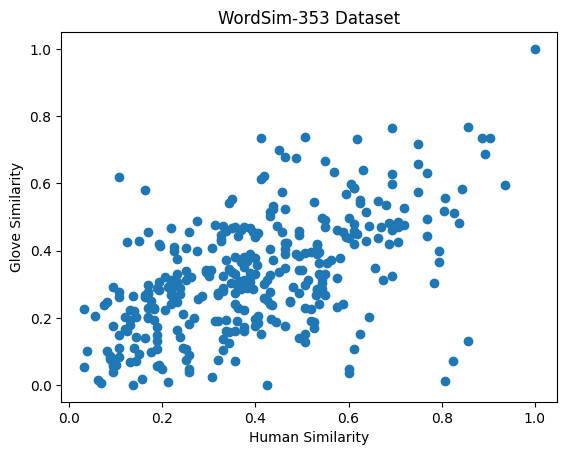

In [124]:
plt.scatter(word_sim_353["human_mean"], word_sim_353["glove_similarity"])
plt.xlabel("Human Similarity")
plt.ylabel("Glove Similarity")
plt.title("WordSim-353 Dataset")
plt.show()

#### Correlation

In [98]:
word_sim_353[["human_mean","glove_similarity"]].corr()

,human_mean,glove_similarity
human_mean,1.000000,0.563558
glove_similarity,0.563558,1.000000


#### Glove Similarity close to Human Similarity

In [70]:
word_sim_353["similarity_diff"] = abs(word_sim_353["human_mean"] - word_sim_353["glove_similarity"])

In [71]:
word_sim_353.sort_values(by="similarity_diff",ascending=[True]).head(10)

,Word 1,Word 2,Human (Mean),human_mean,glove_similarity,similarity_diff
333,tiger,tiger,10.0000,1.00000,1.000000,0.000000
79,delay,racism,0.8750,0.08750,0.087072,0.000428
303,stock,egg,1.4375,0.14375,0.142554,0.001196
125,game,defeat,3.6875,0.36875,0.367238,0.001512
127,game,series,4.5625,0.45625,0.454313,0.001937
341,video,archive,3.4375,0.34375,0.346065,0.002315
213,museum,theater,3.8750,0.38750,0.390163,0.002663
242,possibility,girl,1.0690,0.10690,0.110858,0.003958
145,investigation,effort,3.7500,0.37500,0.380686,0.005686
316,summer,drought,3.3125,0.33125,0.324453,0.006797


#### Outliers - Glove Similarity very different from Human Similarity

In [72]:
outliers = word_sim_353[(word_sim_353["human_mean"]>=0.6) & (word_sim_353["glove_similarity"]<=0.2)]
outliers = pd.concat([outliers, word_sim_353[(word_sim_353["human_mean"]<=0.2) & (word_sim_353["glove_similarity"]>=0.5)]])

In [73]:
outliers

,Word 1,Word 2,Human (Mean),human_mean,glove_similarity,similarity_diff
13,asylum,madhouse,8.0625,0.80625,0.013929,0.792321
71,cup,tableware,6.0000,0.60000,0.048064,0.551936
92,dollar,buck,8.5625,0.85625,0.131307,0.724943
123,fuck,sex,8.2500,0.82500,0.070736,0.754264
231,physics,proton,6.1250,0.61250,0.108245,0.504255
326,tiger,carnivore,6.0000,0.60000,0.035222,0.564778
331,tiger,mammal,6.2500,0.62500,0.151994,0.473006
114,five,month,1.0690,0.10690,0.618711,0.511811
301,start,year,1.6250,0.16250,0.579185,0.416685


### SimLex 999 Dataset

In [74]:
simlex_999 = pd.read_csv("/mnt/d/Acads/2025-Spring/Adv Information Processing/Project 1/SimLex-999.txt", sep="\t")

In [75]:
simlex_999.reset_index(inplace=True)
simlex_999.rename({"index":"word1","word1   word2":"word2"}, axis=1, inplace=True)

In [76]:
simlex_999.head(3)

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19


In [77]:
simlex_999.describe()

,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,4.561572,3.657087,3.568629,2.501502,0.751512,0.333333,1.274505
std,2.614663,1.131050,1.159572,1.118145,1.344569,0.471641,0.366278
min,0.230000,1.190000,1.190000,1.000000,0.000000,0.000000,0.340000
25%,2.380000,2.620000,2.500000,2.000000,0.140000,0.000000,1.075000
50%,4.670000,3.830000,3.660000,3.000000,0.250000,0.000000,1.310000
75%,6.750000,4.790000,4.750000,3.500000,0.680000,1.000000,1.540000
max,9.800000,5.000000,5.000000,4.000000,8.850000,1.000000,2.180000


In [78]:
simlex_999["simlex_similarity"] = simlex_999["SimLex999"]/10

In [83]:
# Getting glove similarity
simlex_999["glove_similarity"] = simlex_999.apply(lambda row: get_glove_similarity(row["word1"], row["word2"]), axis=1)

#### Plot the similarity by Human Annotation and Glove Embeddings

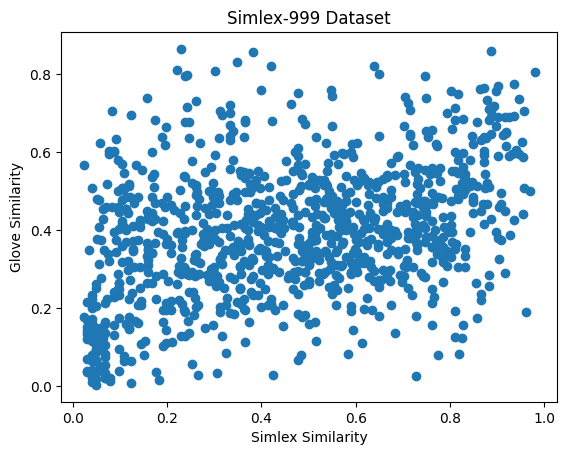

In [125]:
plt.scatter(simlex_999["simlex_similarity"], simlex_999["glove_similarity"])
plt.xlabel("Simlex Similarity")
plt.ylabel("Glove Similarity")
plt.title("Simlex-999 Dataset")
plt.show()

#### Correlation

In [99]:
simlex_999[["simlex_similarity","glove_similarity"]].corr()

,simlex_similarity,glove_similarity
simlex_similarity,1.0000,0.3879
glove_similarity,0.3879,1.0000


#### Glove Similarity close to Human Similarity

In [92]:
simlex_999["similarity_diff"] = abs(simlex_999["simlex_similarity"] - simlex_999["glove_similarity"])

In [93]:
simlex_999.sort_values(by="similarity_diff",ascending=[True]).head(10)

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex),simlex_similarity,glove_similarity,similarity_diff
156,date,calendar,N,4.42,3.90,4.62,3,3.05,1,1.50,0.442,0.441876,0.000124
715,belief,flower,N,0.40,1.19,5.00,2,0.00,0,1.19,0.040,0.039813,0.000187
994,join,acquire,V,2.85,2.86,2.93,2,0.00,0,0.99,0.285,0.285346,0.000346
207,arm,muscle,N,3.72,4.96,4.50,3,1.45,1,0.83,0.372,0.369689,0.002311
677,neck,spine,N,5.32,5.00,4.88,4,0.13,0,1.16,0.532,0.529358,0.002642
101,sly,strange,A,1.97,2.03,1.86,1,0.00,0,1.07,0.197,0.193927,0.003073
46,strong,proud,A,3.17,3.14,2.07,2,0.42,0,1.46,0.317,0.313625,0.003375
223,bar,jail,N,1.90,4.67,4.83,4,1.15,1,1.12,0.190,0.193552,0.003552
843,take,carry,V,5.23,3.06,4.04,2,0.34,0,0.44,0.523,0.527351,0.004351
718,choice,vein,N,0.98,1.90,4.63,2,0.00,0,1.11,0.098,0.093614,0.004386


#### Outliers - Glove Similarity very different from Human Similarity

In [94]:
outliers_simlex = simlex_999[(simlex_999["simlex_similarity"]>=0.7) & (simlex_999["glove_similarity"]<=0.2)]
outliers_simlex = pd.concat([outliers_simlex, simlex_999[(simlex_999["simlex_similarity"]<=0.2) & (simlex_999["glove_similarity"]>=0.6)]])

In [95]:
outliers_simlex

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex),simlex_similarity,glove_similarity,similarity_diff
41,dumb,dense,A,7.27,2.36,3.14,2,0.68,1,0.43,0.727,0.025369,0.701631
205,creator,maker,N,9.62,3.07,3.90,2,1.51,1,1.40,0.962,0.190231,0.771769
208,bubble,suds,N,8.57,4.60,4.59,3,1.42,1,1.59,0.857,0.173415,0.683585
391,leader,manager,N,7.27,3.89,4.14,3,0.34,0,1.43,0.727,0.179078,0.547922
515,rabbi,minister,N,7.62,4.64,4.22,3,0.20,0,1.35,0.762,0.155014,0.606986
527,racket,noise,N,8.10,4.26,3.52,3,0.19,0,1.49,0.810,0.124864,0.685136
780,think,rationalize,V,8.25,2.41,1.52,1,3.17,1,1.13,0.825,0.122961,0.702039
785,begin,originate,V,8.20,2.56,2.23,1,2.44,1,0.75,0.820,0.081010,0.738990
818,keep,possess,V,8.27,2.37,2.60,1,0.62,1,0.80,0.827,0.156985,0.670015
969,join,add,V,8.10,2.86,3.00,2,0.11,0,0.88,0.810,0.193115,0.616885
